In [1]:
# set up autoreload
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from dataset import DataManager, FrameDataGenerator

# check gpu
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

2023-12-07 11:22:26.315423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 11:22:27.954106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ji/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.8'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-07 11:22:29.531397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 11:22:29.750786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 11:22:29.751159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [48]:
# set up data generator
data_manager = DataManager(
        data_path=r"/home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data",
        train_val_test_split=(0.80,0.1,0.1))

data_manager_small = DataManager(
        data_path=r"/home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data_Test",
        train_val_test_split=(1.0,0.0,0.0))

2023-12-07 11:40:08.255 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-06_09-22-28.avi
2023-12-07 11:40:08.257 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-12_09-53-23.avi
2023-12-07 11:40:08.258 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-06_09-42-29.avi
2023-12-07 11:40:08.259 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-27_09-55-04.avi
2023-12-07 11:40:08.260 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-09_10-13-05.avi
2023-12-07 11:40:08.260 | INFO     | dataset:__init__:29 - Found video file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Da

In [50]:
# set up tf database
config = {}
config["fold_n_frames"] = 10 # fold n frames to predict the n+1 frame
img_h, img_w = 96,128
config['frame_resize_reshape'] = (img_h,img_w)
# train/val/test data loader
train_loader = FrameDataGenerator(file_list=data_manager.get_training_files(),
                                    config=config)
val_loader = FrameDataGenerator(file_list=data_manager.get_validation_files(),
                                    config=config)
test_loader = FrameDataGenerator(file_list=data_manager.get_test_files(),
                                    config=config)
train_loader_small = FrameDataGenerator(file_list=data_manager_small.get_training_files(),
                                    config=config)

# create tensorflow database from the generator
action_dim = 4 # the txt files have 7 columns,but only 4 are used
nchan_ori=1 # convert to gray scale
output_signature = ((tf.TensorSpec(shape = (img_h, img_w, nchan_ori*config["fold_n_frames"]),
                                    dtype = train_loader.frame_dtype),
                     tf.TensorSpec(shape = (action_dim,),
                                    dtype = train_loader.action_dtype)),
                    tf.TensorSpec(shape = (img_h, img_w, nchan_ori),
                                    dtype = train_loader.frame_dtype),
                    )
    
# create train/val/test tf dataset
train_ds = tf.data.Dataset.from_generator(train_loader,
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_loader,
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(test_loader,
                                          output_signature = output_signature)


# set up batch size
train_ds = train_ds.batch(8)
train_ds = train_ds.prefetch(buffer_size = 20)


# for validation and test evaluation, we are gonna sample
# mini batches and calculate the loss, and repeat several
# times and compute the mean loss, as opposed to compute 
# the loss on the whole validation/test set, so we can use
# the same data generation pipeline built for the training
# set
val_ds = val_ds.batch(8)
val_ds = val_ds.prefetch(buffer_size = 20)
test_ds = test_ds.batch(8)
test_ds = test_ds.prefetch(buffer_size = 20)

train_ds_small = tf.data.Dataset.from_generator(train_loader_small,
                                          output_signature = output_signature)
train_ds_small = train_ds_small.batch(8)
train_ds_small = train_ds_small.prefetch(5)

2023-12-07 11:40:18.180 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-10-24_10-18-15_merge.txt
2023-12-07 11:40:18.182 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-13_09-42-17_merge.txt
2023-12-07 11:40:18.183 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-09_10-13-05_merge.txt
2023-12-07 11:40:18.186 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-09_10-18-05_merge.txt
2023-12-07 11:40:18.191 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robotics/ENPM809K_Fundamentals_in_AI_and_DL/Data/Data_2023-11-06_09-27-29_merge.txt
2023-12-07 11:40:18.193 | INFO     | dataset:__init__:127 - Found action file: /home/ji/Dropbox/Robo

some functions for figuring out conv and conv2dtr dimensions

In [ ]:
# image in
def outdim(d,f,p,s):
    return np.floor(d+2*p-f)/s+1

# image out size
def outdim_conv2d_tr(d,f,p,s, output_padding):
    return ((d-1)*s+f-2*p+output_padding)

d1 = outdim(192,8,0,2)
d2 = outdim(d1,6,0,2)
d3 = outdim(d2,6,0,2)
d4 = outdim(d3,4,0,2)
print(d4)

d4_ = outdim_conv2d_tr(d4,4,0,2,0)
d3_ = outdim_conv2d_tr(d4_,6,0,2,0)
d2_ = outdim_conv2d_tr(d3_,6,0,2,1)
d1_ = outdim_conv2d_tr(d2_,8,0,2,0)
print(d1_)

In [74]:
from model import get_interaction_module, FramePredictionModel, custom_loss

# some hyper parameters for the network
img_dim = (img_h,img_w,nchan_ori*config["fold_n_frames"])
encoder_output_dim = 2048

# set up models
layer_specs = [
                {"type":"input","kwargs":{"input_shape":img_dim}}, #0
                {"type":"conv2d","kwargs":{"filters": 128,  "kernel_size": 8, "strides":2,"activation":"relu"}}, #1
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #2
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #4
                {"type":"flatten"}, #5
                {"type":"dense","kwargs":{"units":encoder_output_dim,"activation":"relu"}} #6
            ]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_dim),
    tf.keras.layers.Conv2D(**layer_specs[1]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[2]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(encoder_output_dim, activation='relu')
])

# define interaction module
interaction_dim, interaction_output_dim = 2048, 2048
interaction = get_interaction_module(encoder_dim=encoder_output_dim,
                                     action_dim=action_dim,
                                     intermediate_dim=interaction_dim,
                                     output_dim=interaction_output_dim)

# interaction = tf.keras.Sequential(
#     [
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=interaction_output_dim,activation='relu'),
#     ]
# )

# define decoder
# get the output size of the last conv layer
conv_out_size = encoder.layers[6].output_shape[1:]
nchan = 128
fc_dim = int(np.prod(conv_out_size[:2])*nchan)
layer_specs = [
                {"type":"input_shape","kwargs":{"shape":(interaction_output_dim,)}}, #0
                {"type":"dense","kwargs":{"units":fc_dim,"activation":"relu"}}, #1
                {"type":"reshape","kwargs":{"target_shape":(conv_out_size[0],conv_out_size[1],nchan)}}, #2
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #4
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu", "output_padding":1}}, #5
                {"type":"conv2dtr","kwargs":{"filters": nchan_ori, "kernel_size": 8, "strides":2,"activation":None}}, #6
                ]

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(interaction_output_dim,)),
    tf.keras.layers.Dense(units=fc_dim,activation='relu'),
    tf.keras.layers.Reshape(target_shape=(conv_out_size[0],conv_out_size[1],nchan)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[5]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[6]["kwargs"]),
])

# print('output shape of decoder: ', decoder.output_shape)
# make sure decoder output matches the input image's size
assert(decoder.output_shape[1:3]==img_dim[:2])
assert(decoder.output_shape[-1]==nchan_ori)

# get full model
fpm = FramePredictionModel(img_dim,action_dim,encoder,interaction,decoder)
fpm.build(input_shape=[(None, *img_dim),(None,action_dim)])
print(fpm.summary())

# test with some sample data
(frame_input_sample,actions_sample), frame_output_sample = next(iter(train_ds_small))
out_test = fpm([frame_input_sample, actions_sample])
assert(out_test.shape==frame_output_sample.shape)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpm.compile(optimizer=optimizer,
            loss=custom_loss(),
            metrics=[tfa.metrics.r_square.RSquare(name="r2")]
            )


Model: "frame_prediction_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 2048)              5460480   
                                                                 
 sequential_22 (Sequential)  (None, 96, 128, 1)        5385985   
                                                                 
 model (Functional)          (None, 2048)              11362816  
                                                                 
Total params: 22,209,281
Trainable params: 22,200,321
Non-trainable params: 8,960
_________________________________________________________________
None


-0.65392244 2.0220459


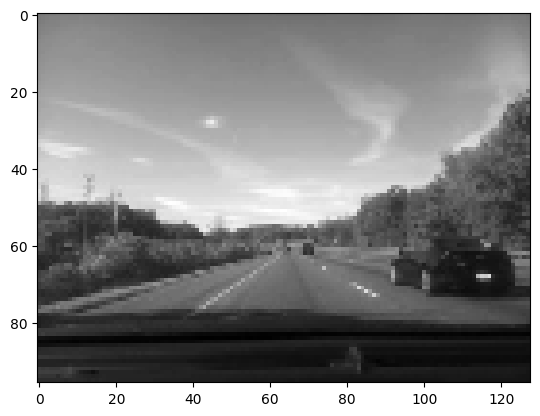

In [56]:
import matplotlib.pyplot as plt
(frame_input_sample,actions_sample), frame_output_sample = next(iter(train_ds_small))
print(np.mean(frame_input_sample.numpy().flatten()),np.std(frame_input_sample.numpy().flatten()) )
plt.imshow(frame_input_sample[0,:,:,0],cmap='gray')
plt.show()

In [ ]:
(frame_input_sample,actions_sample), frame_output_sample = next(iter(train_ds_small))
print(actions_sample)

In [ ]:
plt.figure(figsize=(16,8))
nrow = 3
ncol = 5
for i in range(nrow):
    for j in range(ncol):
        ind = int(i*ncol+j)
        plt.subplot(nrow,ncol,ind+1)
        plt.imshow(frame_input_sample[0,:,:,ind],cmap='gray',vmin=-2,vmax=2)
plt.show()


# Do an overfit on a small dataset

In [76]:
test_epochs = 100
history = fpm.fit(train_ds_small,epochs=test_epochs, verbose=True,steps_per_epoch=112)

Epoch 1/100
112/112 [==============================] - 30s 265ms/step - loss: 1.6858
Epoch 2/100
112/112 [==============================] - 27s 244ms/step - loss: 1.7973
Epoch 3/100
112/112 [==============================] - 27s 243ms/step - loss: 1.6732
Epoch 4/100
112/112 [==============================] - 32s 286ms/step - loss: 1.6507
Epoch 5/100
112/112 [==============================] - 28s 250ms/step - loss: 1.6768
Epoch 6/100
112/112 [==============================] - 29s 257ms/step - loss: 1.6288
Epoch 7/100
112/112 [==============================] - 30s 268ms/step - loss: 1.6963
Epoch 8/100
112/112 [==============================] - 27s 239ms/step - loss: 1.5613
Epoch 9/100
112/112 [==============================] - 27s 241ms/step - loss: 1.5288
Epoch 10/100
112/112 [==============================] - 26s 232ms/step - loss: 1.5135
Epoch 11/100
112/112 [==============================] - 26s 234ms/step - loss: 1.5773
Epoch 12/100
112/112 [==============================] - 27s 239

In [83]:
history2 = fpm.fit(train_ds_small,epochs=test_epochs, verbose=True,steps_per_epoch=112)

Epoch 1/100
112/112 [==============================] - 26s 232ms/step - loss: 0.6550
Epoch 2/100
112/112 [==============================] - 26s 231ms/step - loss: 0.6479
Epoch 3/100
112/112 [==============================] - 26s 233ms/step - loss: 0.6063
Epoch 4/100
112/112 [==============================] - 26s 233ms/step - loss: 0.6430
Epoch 5/100
112/112 [==============================] - 26s 230ms/step - loss: 0.6507
Epoch 6/100
112/112 [==============================] - 26s 230ms/step - loss: 0.6539
Epoch 7/100
112/112 [==============================] - 26s 235ms/step - loss: 0.6262
Epoch 8/100
112/112 [==============================] - 27s 242ms/step - loss: 0.6492
Epoch 9/100
112/112 [==============================] - 26s 234ms/step - loss: 0.6257
Epoch 10/100
112/112 [==============================] - 28s 249ms/step - loss: 0.6767
Epoch 11/100
112/112 [==============================] - 26s 234ms/step - loss: 0.7552
Epoch 12/100
112/112 [==============================] - 26s 236

In [ ]:
len(data)

In [59]:
i=0
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
while True:
    feature_in, frame_out= next(iter(train_ds_small))
    # compute loss
    with tf.GradientTape() as tape:
        frame_out_pred = fpm(feature_in, training=True)
        loss_value = fpm.compute_loss(y=frame_out, y_pred=frame_out_pred)
    # apply gradient
    grad = tape.gradient(loss_value, fpm.trainable_variables)
    optimizer.apply_gradients(zip(grad, fpm.trainable_variables))

    i+=1
    if i%10==0:
        print(loss_value.numpy())
    if i>=300:
        break
    

KeyboardInterrupt: 

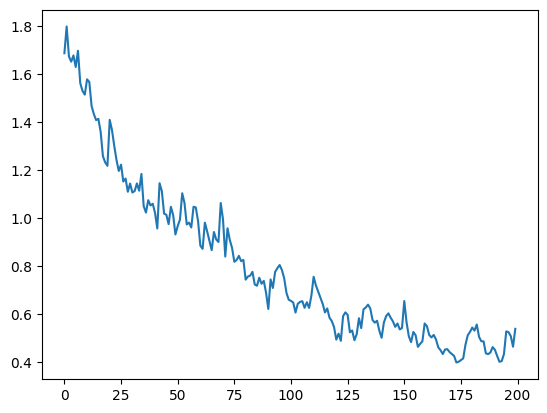

In [119]:
plt.plot(history.history['loss']+history2.history['loss'])

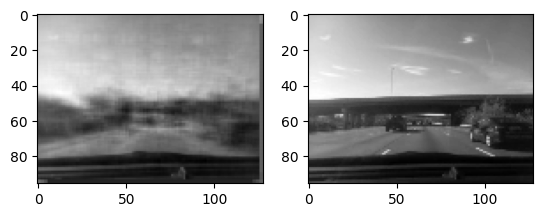

In [116]:
import matplotlib.pyplot as plt
feature_in, frame_out= next(iter(train_ds_small))
# compute loss
frame_out_pred = fpm(feature_in, training=False)
plt.subplot(1,2,1)
plt.imshow(frame_out_pred[0,:,:],'gray')
plt.subplot(1,2,2)
plt.imshow(frame_out[0,:,:],'gray')